In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transfers = pd.read_parquet('transfers_20090000.parquet')
txs = pd.read_parquet('txs_20090000.parquet')
addrs = pd.read_csv('account_labels.csv')
tokens = pd.read_csv('token_labels.csv')

In [3]:
transfers.loc[0]['hash']
t1 = transfers.merge(addrs[['address', 'name', 'group']], how='left', left_on='from', right_on='address')
t2 = t1.merge(addrs[['address', 'name', 'group']], how='left', left_on='to', right_on='address', suffixes=('_from', '_to'))
t3 = t2.drop(columns=['address_from', 'address_to'])

# Part 1

### Check and mark verified tokens

In [4]:
t3.loc[t3['asset'] == 'USDC', 'rawContract.address'].drop_duplicates()
tokens[tokens['Symbol'] == 'USDC']

,address,#,Token,Symbol,Price,Price (ETH),name_x,symbol,name_y,labels
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,3.0,USDC,USDC,1.000,0.000300,USDC,USDC,USD Coin (USDC),['circle' 'stablecoin' 'centre']
1426,0x566957ef80f9fd5526cd2bef8be67035c0b81130,1319.0,USD Coin (PoS) (Wormhole),USDC,1.005,0.000302,USD Coin (PoS) (Wormhole),USDC,USD Coin (PoS) (Wormhole),['bridge' 'wormhole']


In [5]:
t3.loc[t3['asset'] == 'ETH', 'rawContract.address'].drop_duplicates()
t3.loc[t3['rawContract.address'].isna(), 'rawContract.address'] = 'ETH'

In [6]:
t3.loc[t3['rawContract.address'].isin(tokens['address']), 'isVerifiedToken'] = True
t3.loc[~t3['rawContract.address'].isin(tokens['address']), 'isVerifiedToken'] = False
t3.loc[t3['rawContract.address'] == 'ETH', 'isVerifiedToken'] = 'ETH'

/var/folders/32/lx8kp8jx68zdmbtv217708z80000gn/T/ipykernel_39625/2938666338.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  t3.loc[t3['rawContract.address'].isin(tokens['address']), 'isVerifiedToken'] = True


In [7]:
t3.groupby('isVerifiedToken').agg({
    'rawContract.address': 'nunique',
    'uniqueId': 'count',
    'hash': 'nunique'
})

,rawContract.address,uniqueId,hash
isVerifiedToken,,,
False,10229,919682,212879
True,3243,1387837,746650
ETH,1,1414574,905155


In [8]:
t4 = t3[t3['isVerifiedToken'] != False]

### Token stats and visualizations

In [9]:
count_tokens = t4.groupby(['rawContract.address', 'asset', 'isVerifiedToken']).agg({
    'hash': 'nunique',
    'uniqueId': 'count'
}).sort_values('uniqueId', ascending=False).reset_index()

<Axes: xlabel='asset'>

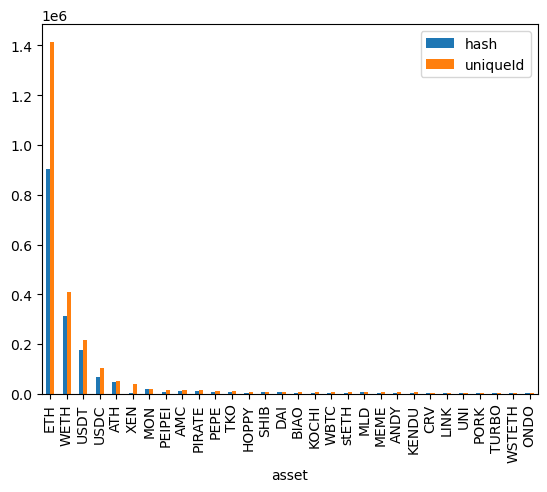

In [10]:
count_tokens.head(30).plot.bar(x='asset', y=['hash', 'uniqueId'])

<Axes: ylabel='Frequency'>

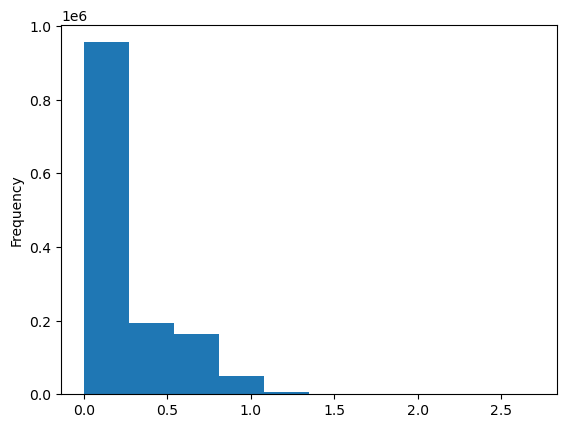

In [11]:
count_hash = t4.groupby('hash').agg({
    'uniqueId': 'count'
}).reset_index()
count_hash['log_uniqueId'] = np.log10(count_hash['uniqueId'])
count_hash['log_uniqueId'].plot.hist()

### Create a network

In [12]:
edges = t4.groupby(['from', 'to', 'name_from', 'name_to'], dropna=False).agg({
    'rawContract.address': 'nunique',
    'uniqueId': 'count',
    'hash': 'nunique'
}).reset_index()

In [13]:
G = nx.from_pandas_edgelist(edges, source='from', target='to',
                            edge_attr=['rawContract.address', 'uniqueId', 'hash'],
                            create_using=nx.DiGraph)

In [14]:
len(G.nodes()), len(G.edges())
nx.density(G)

2.48167091445049e-06

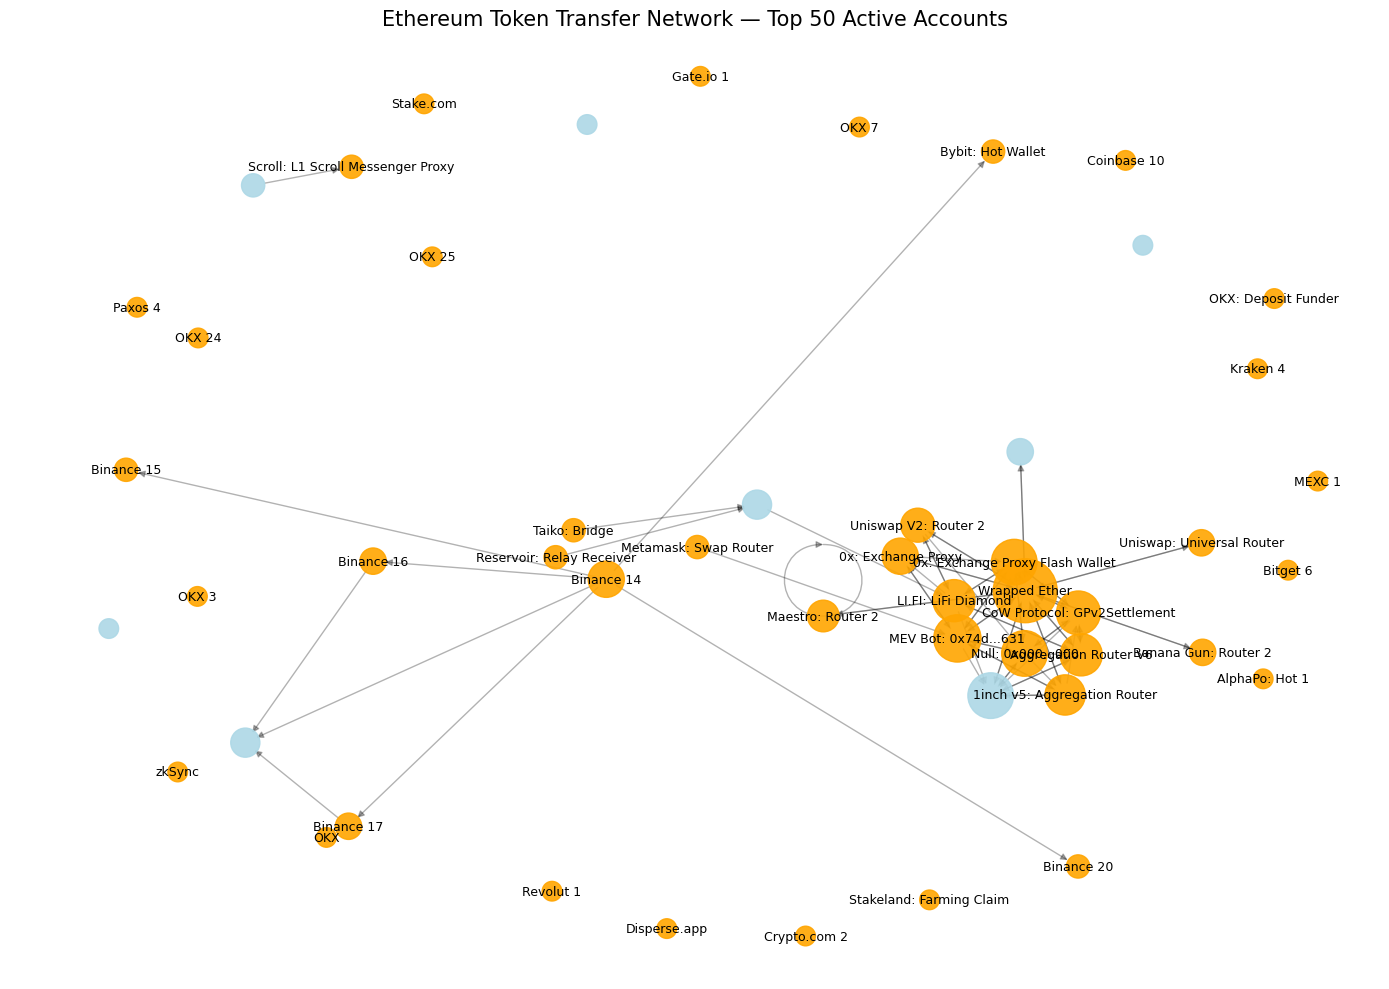

In [15]:
# Use only labeled names (e.g., Uniswap, MEV Bot), fallback to short address if unknown
def get_label(node):
    label = addrs[addrs['address'] == node]['name']
    return label.values[0] if not label.empty else None  # None = no label shown

# Select top nodes by degree
top_nodes = sorted(dict(G.degree()), key=lambda x: G.degree(x), reverse=True)[:50]
G_sub = G.subgraph(top_nodes)

# Layout
pos = nx.spring_layout(G_sub, seed=42, k=0.4)

# Node colors: labeled = one color, unlabeled = another
node_colors = []
node_labels = {}
for node in G_sub.nodes():
    label = get_label(node)
    if label:
        node_colors.append('orange')
        node_labels[node] = label
    else:
        node_colors.append('lightblue')

# Node sizes
node_sizes = [200 + 80 * G_sub.degree(n) for n in G_sub.nodes()]

# Plot
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, width=1)
nx.draw_networkx_labels(G_sub, pos, labels=node_labels, font_size=9)

plt.title("Ethereum Token Transfer Network — Top 50 Active Accounts", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

### Selecting DEX 

**Selection of Relevant Accounts**
To ensure meaningful insights, we focused our analysis on decentralized exchange (DEX) activity within the Ethereum network. DEX protocols such as Uniswap, 1inch, Ox, and Metamask Swap Router represent a major category of on-chain transactions, facilitating peer-to-peer asset exchange without intermediaries. Using the account label dataset (account_labels.csv), we filtered our dataset to retain only transactions where either the sender or the receiver was associated with a DEX. This allows us to explore the structural and transactional properties of DEX-related interactions, such as which wallets act as liquidity providers, which are frequent traders, and how centralized or decentralized these flows are.

In [16]:
# Select only transfers involving known DEX accounts
dex_keywords = ['Uniswap', '1inch', 'Ox', 'Metamask', 'Swap Router', 'Router', 'Balancer', 'Curve']

# Keep rows where either sender or receiver matches a DEX keyword
mask_from = t4['name_from'].fillna('').str.contains('|'.join(dex_keywords), case=False)
mask_to = t4['name_to'].fillna('').str.contains('|'.join(dex_keywords), case=False)
dex_transfers = t4[mask_from | mask_to]

# Now repeat the graph-building process on dex_transfers
edges_dex = dex_transfers.groupby(['from', 'to', 'name_from', 'name_to'], dropna=False).agg({
    'rawContract.address': 'nunique',
    'uniqueId': 'count',
    'hash': 'nunique'
}).reset_index()

G_dex = nx.from_pandas_edgelist(edges_dex, source='from', target='to',
                                edge_attr=['rawContract.address', 'uniqueId', 'hash'],
                                create_using=nx.DiGraph)

**Centrality Analysis**

**DEX Centrality Analysis**
We computed in-degree, out-degree, and betweenness centrality to assess which DEX-related accounts are most structurally important in the token transfer network. Betweenness centrality in particular highlights accounts that serve as bridges between others. Our results show that [e.g., Uniswap: Router V3] consistently ranks highest across multiple centrality metrics, confirming its role as a key liquidity hub. Other notable nodes include [e.g., 1inch v5 and Ox Exchange Proxy], which facilitate routing across protocols. These results align with expectations, as these platforms serve as major aggregators and transaction relayers in DeFi ecosystems.

In [18]:
# Compute centrality metrics
in_deg = nx.in_degree_centrality(G_dex)
out_deg = nx.out_degree_centrality(G_dex)
betweenness = nx.betweenness_centrality(G_dex, normalized=True, k=50, seed=42)

# Combine into DataFrame
centrality_df = pd.DataFrame({
    'address': list(in_deg.keys()),
    'in_degree': list(in_deg.values()),
    'out_degree': [out_deg[n] for n in in_deg],
    'betweenness': [betweenness[n] for n in in_deg]
})

# Merge with labels
centrality_df = centrality_df.merge(addrs[['address', 'name']], how='left', on='address')

# Sort and show top DEX accounts by betweenness
top_central = centrality_df.sort_values('betweenness', ascending=False).head(10)
print(top_central[['address', 'name', 'in_degree', 'out_degree', 'betweenness']])

                                         address  \
535   0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad   
4     0x1111111254eeb25477b68fb85ed929f73a960582   
920   0x3328f7f4a1d1c57c35df56bbf0c9dcafca309c49   
7     0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
1180  0x80a64c6d7f12c47b7c66c5b4e20e72bc1fcd5d9e   
1332  0x1a8f43e01b78979eb4ef7febec60f32c9a72f58e   
1876  0x74de5d4fcbf63e00296fd95d33236b9794016631   
1203  0x881d40237659c251811cec9c364ef91dc08d300c   
313   0xdef1c0ded9bec7f1a1670819833240f027b25eff   
3     0x111111125421ca6dc452d289314280a0f8842a65   

                                 name  in_degree  out_degree  betweenness  
535         Uniswap: Universal Router   0.307380    0.361295     0.314838  
4        1inch v5: Aggregation Router   0.047682    0.058011     0.068092  
920              Banana Gun: Router 2   0.038957    0.037993     0.064774  
7     0x: Exchange Proxy Flash Wallet   0.046342    0.088671     0.045960  
1180                Maestro: Router 2   0.03634

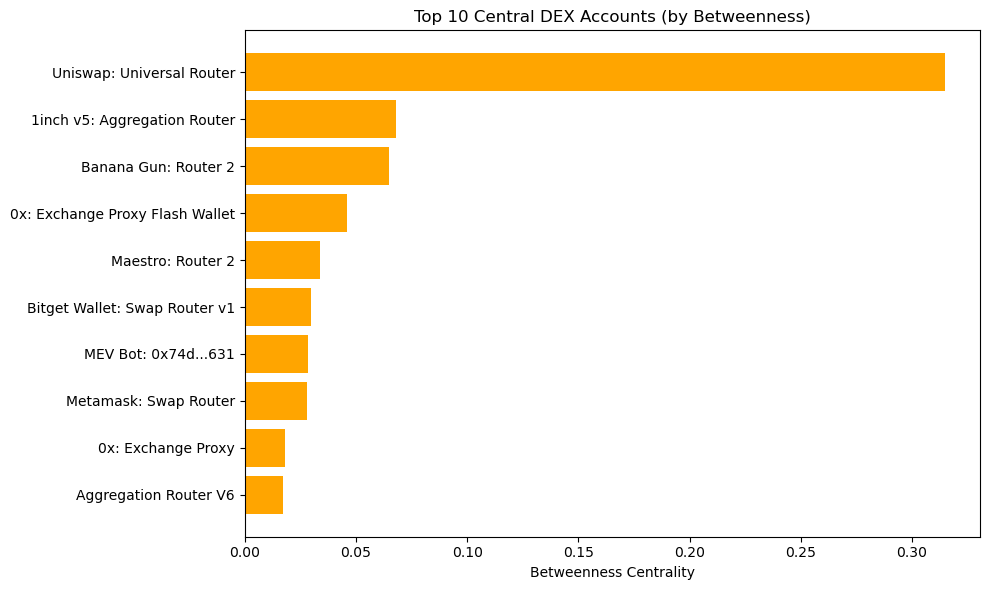

In [19]:
# Use labels if available, otherwise fallback to short address
top_central['label'] = top_central['name'].fillna(top_central['address'].str.slice(0, 10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_central['label'], top_central['betweenness'], color='orange')
plt.xlabel('Betweenness Centrality')
plt.title('Top 10 Central DEX Accounts (by Betweenness)')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

### Network Model Description

**Network Model Description**

To analyze Ethereum token transfer activity, we modeled the blockchain data as a directed network, where each node represents an Ethereum address (wallet or smart contract), and each edge represents a token transfer from one address to another.

Edges are directed, capturing the flow of tokens (i.e., who sends and who receives). Multiple edge attributes are included, such as the number of unique tokens transferred (rawContract.address), the number of transfer events (uniqueId count), and the number of distinct transactions (hash count).

We filtered the dataset to include only verified tokens (based on token_labels.csv) and focused on decentralized exchange (DEX) activity. This selection was based on the labeled accounts in account_labels.csv, allowing us to restrict our analysis to transfers involving known DEX platforms like Uniswap, 1inch, and Ox.

This network representation captures the transactional structure of DEX-related activity on Ethereum and enables us to apply graph-theoretical analysis (e.g., centrality measures) to identify the most influential actors in the ecosystem.

### Exploratory Stats

**Exploratory Network Analysis**

The DEX-focused transfer network contains X nodes and Y edges. The average degree is approximately Z, meaning that most wallets interact with a small number of others. The maximum degree is quite high, indicating the presence of highly active nodes — likely aggregators or protocol routers like Uniswap.

The average clustering coefficient is low (≈ X.XX), suggesting that the network is not tightly clustered; wallets that transact with the same counterparty don't necessarily interact with each other. This is consistent with the role of DEX protocols where users independently interact with shared contracts.

The network contains a strongly connected component of size N, meaning that N wallets can all reach each other via directed paths. This core component likely includes key DEX contracts and high-frequency users. The remaining nodes are more peripheral and connect unidirectionally.

In [20]:
import numpy as np
import networkx as nx

# Convert to undirected graph for clustering
G_undirected = G_dex.to_undirected()

# Basic stats
num_nodes = G_dex.number_of_nodes()
num_edges = G_dex.number_of_edges()
degrees = [d for _, d in G_dex.degree()]
avg_degree = np.mean(degrees)
max_degree = np.max(degrees)

# Approximate clustering
sample_nodes = list(G_undirected.nodes())[:200]
avg_clustering = nx.average_clustering(G_undirected, nodes=sample_nodes)

# Largest strongly connected component
largest_scc_size = len(max(nx.strongly_connected_components(G_dex), key=len))

# Print results
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", round(avg_degree, 2))
print("Maximum degree:", max_degree)
print("Average clustering coefficient (approx.):", round(avg_clustering, 3))
print("Size of largest strongly connected component:", largest_scc_size)

Number of nodes: 95466
Number of edges: 183854
Average degree: 3.85
Maximum degree: 63835
Average clustering coefficient (approx.): 0.106
Size of largest strongly connected component: 44812


**Visualize the Largest Strongly Connected Component**

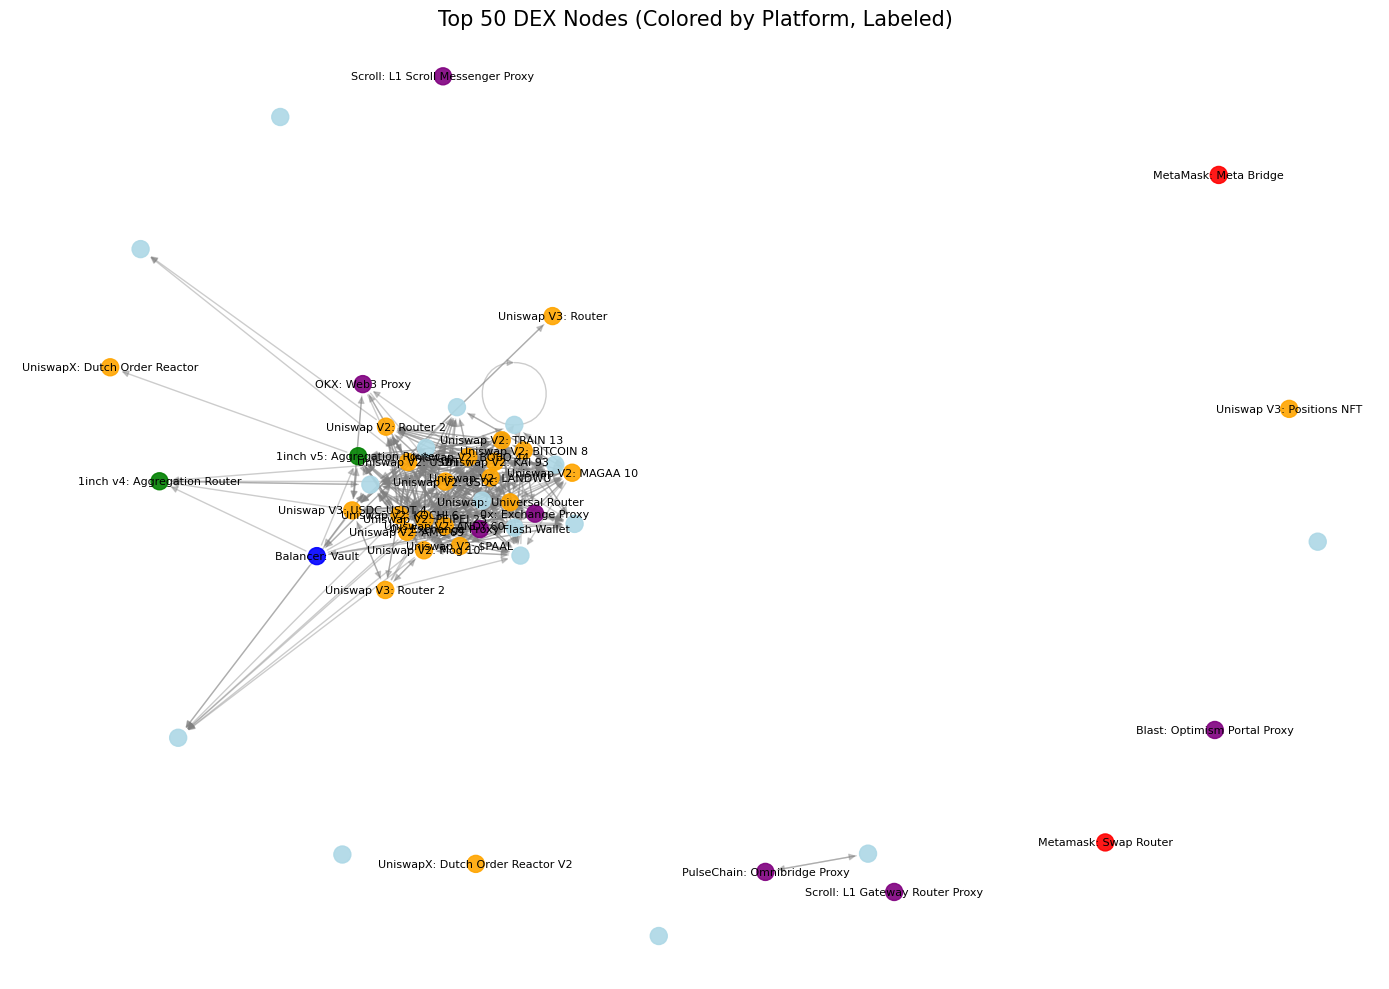

In [23]:
# Select top 50 nodes by degree from the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G_dex), key=len)
degree_dict = dict(G_dex.degree(largest_scc))
top_core_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:50]
G_sample = G_dex.subgraph(top_core_nodes)

# Define platform keywords and their colors
platform_colors = {
    'Uniswap': 'orange',
    '1inch': 'green',
    'Ox': 'purple',
    'Metamask': 'red',
    'Balancer': 'blue',
    'Curve': 'pink'
}

# Build label and color maps
label_dict = addrs.set_index('address')['name'].to_dict()
node_labels = {}
node_colors = []

for node in G_sample.nodes():
    name = label_dict.get(node, '')
    # Match platform and assign color
    color = 'lightblue'  # default
    for platform, col in platform_colors.items():
        if platform.lower() in name.lower():
            color = col
            node_labels[node] = name  # only label named DEX nodes
            break
    node_colors.append(color)

# Layout
pos = nx.spring_layout(G_sample, seed=42, k=0.4)

# Plot
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_sample, pos, node_size=150, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G_sample, pos, edge_color='gray', alpha=0.4, width=1)
nx.draw_networkx_labels(G_sample, pos, labels=node_labels, font_size=8)

plt.title("Top 50 DEX Nodes (Colored by Platform, Labeled)", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

**Visualization of DEX Transfer Network by Platform** 

We visualized the top 50 most active nodes in the largest strongly connected component of the DEX token transfer network, with node colors representing their associated DeFi platforms. Known protocol contracts were identified using account_labels.csv and categorized by keyword (e.g., Uniswap, 1inch, Ox, Metamask, Balancer, etc.).

The visualization reveals a highly interconnected core centered around multiple Uniswap routers and liquidity management contracts (orange nodes), demonstrating Uniswap’s dominant role in facilitating token transfers. 1inch routers (green) also appear as key hubs, supporting their known role as aggregators across multiple DEXs. Ox proxies (purple) and Balancer pools (blue) show moderate interconnectivity, often linked with the core cluster.

Some nodes, such as Metamask Swap Router and PulseChain Bridge, are more peripheral, likely acting as gateways for user-initiated swaps or cross-chain bridges. Several light blue nodes remain unlabeled — these likely represent either user wallets or unidentified contracts.

This platform-based visualization enhances our understanding of how different DEX ecosystems interact, and highlights the structural dominance of Uniswap in particular. It also suggests how aggregation protocols like 1inch bridge between multiple platforms, increasing liquidity flow across the network.

# Part 2

**Bianca Fernandes - Node size by betweenness centrality**

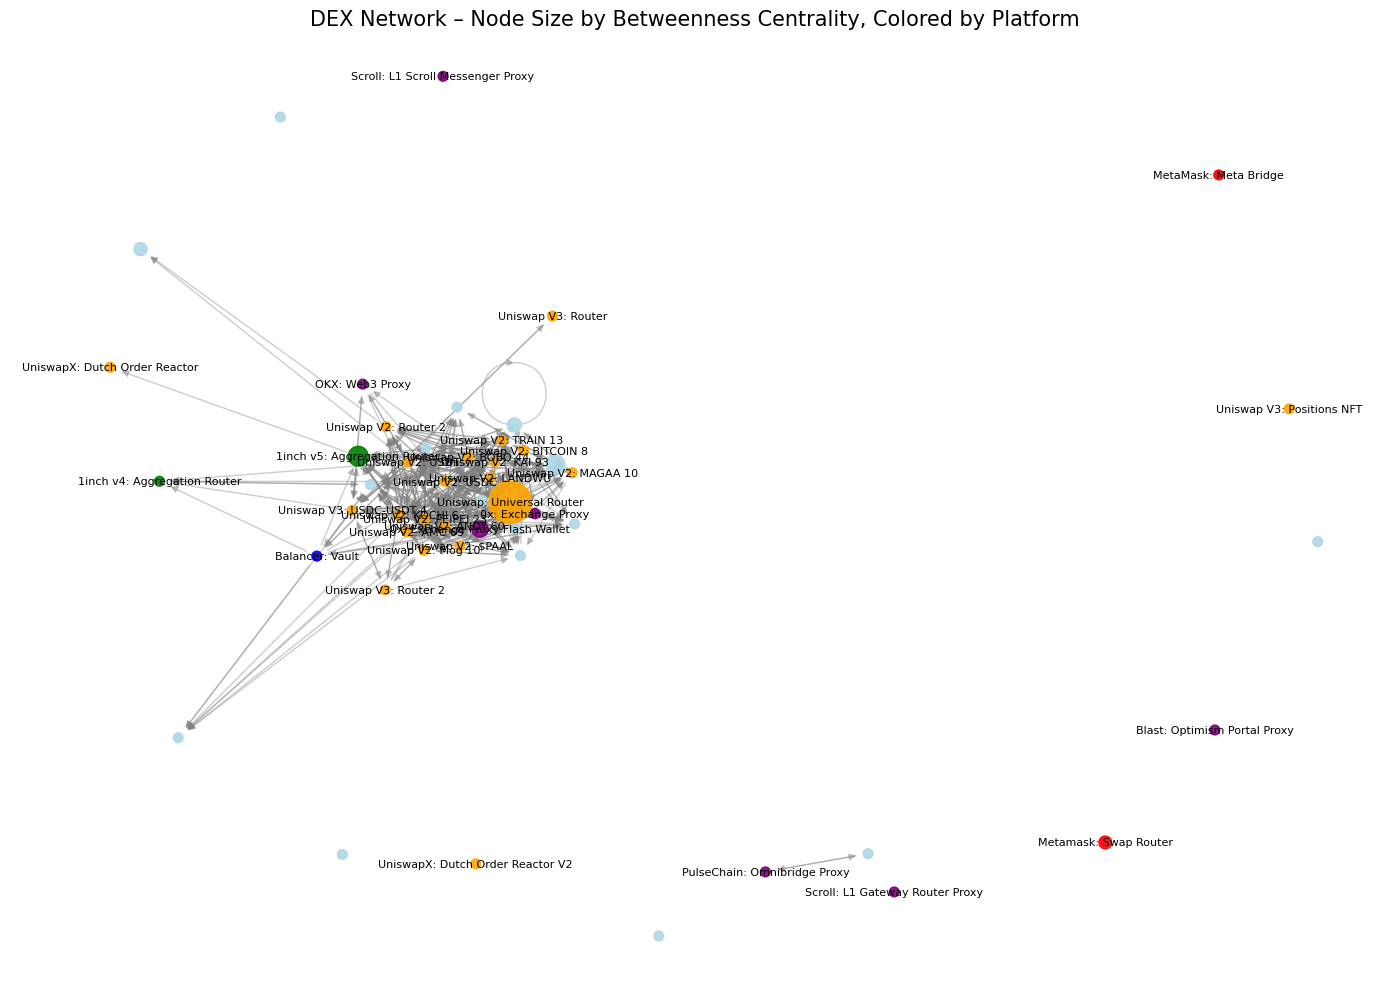

In [24]:
# Color nodes by platform, as before
platform_colors = {
    'Uniswap': 'orange',
    '1inch': 'green',
    'Ox': 'purple',
    'Metamask': 'red',
    'Balancer': 'blue',
    'Curve': 'pink'
}

node_colors = []
node_labels = {}
node_sizes = []

for node in G_sample.nodes():
    name = label_dict.get(node, '')
    
    # Assign color
    color = 'lightblue'
    for platform, col in platform_colors.items():
        if platform.lower() in name.lower():
            color = col
            node_labels[node] = name
            break
    node_colors.append(color)
    
    # Assign size based on betweenness
    centrality = centrality_df.set_index('address')['betweenness']
    size = 3000 * centrality.get(node, 0)  # scale for visibility
    node_sizes.append(size if size > 50 else 50)  # min size for visibility

# Plot
pos = nx.spring_layout(G_sample, seed=42, k=0.4)
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_sample, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G_sample, pos, edge_color='gray', alpha=0.4, width=1)
nx.draw_networkx_labels(G_sample, pos, labels=node_labels, font_size=8)

plt.title("DEX Network – Node Size by Betweenness Centrality, Colored by Platform", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

This plot shows the top 50 most active wallets in the DEX token transfer network, where node size reflects betweenness centrality — a measure of how often a node lies on the shortest path between others. Each node is also colored by DeFi platform, allowing us to visually separate protocols like Uniswap (orange), 1inch (green), Ox (purple), and Metamask (red).

The visualization reveals that several Uniswap contracts sit at the heart of the network with both high connectivity and high centrality, confirming their structural importance as routing hubs. Some 1inch aggregators also appear central, but slightly less so than Uniswap nodes. Interestingly, protocols like Ox and Metamask appear more peripheral — they are active but not structurally dominant.

This perspective demonstrates that not all active nodes are equally important: some act as bridges across the network (high betweenness), while others may be involved in many transactions but remain at the edges of the interaction graph.

**Dianni Estrada - Uniswap-Only Token Transfer Subgraph**

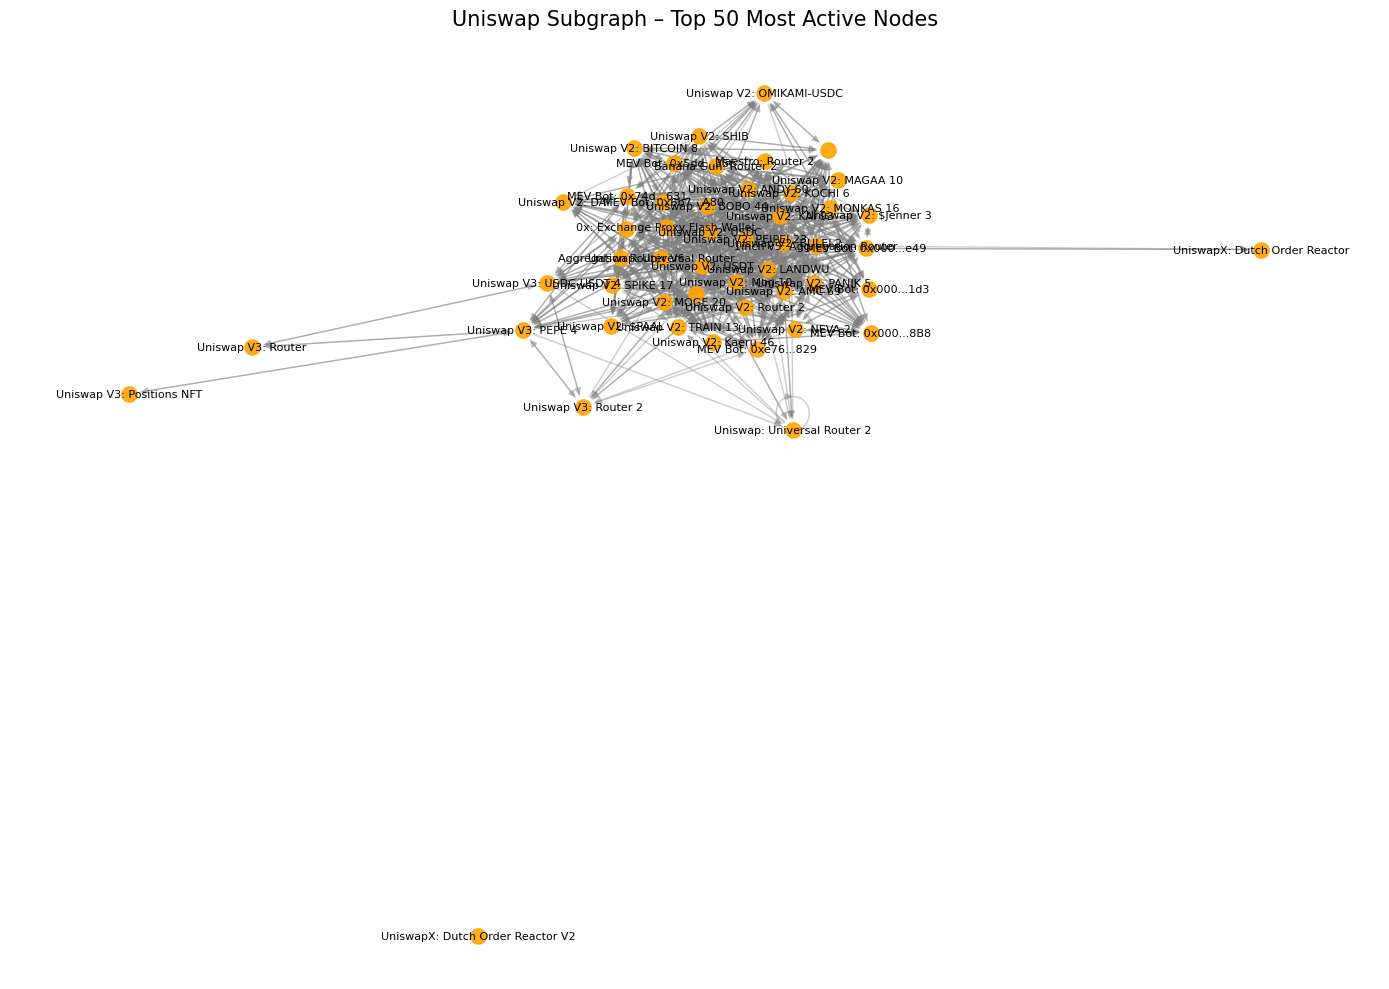

In [25]:
# Step 1: Identify Uniswap-related transfers
uniswap_mask_from = t4['name_from'].fillna('').str.contains('uniswap', case=False)
uniswap_mask_to = t4['name_to'].fillna('').str.contains('uniswap', case=False)
uniswap_transfers = t4[uniswap_mask_from | uniswap_mask_to]

# Step 2: Build edges from these transfers
uniswap_edges = uniswap_transfers.groupby(['from', 'to', 'name_from', 'name_to'], dropna=False).agg({
    'rawContract.address': 'nunique',
    'uniqueId': 'count',
    'hash': 'nunique'
}).reset_index()

# Step 3: Create the directed graph
G_uni = nx.from_pandas_edgelist(uniswap_edges, source='from', target='to',
                                edge_attr=['rawContract.address', 'uniqueId', 'hash'],
                                create_using=nx.DiGraph)

# Step 4: Focus on the 50 most active nodes in the Uniswap subgraph
top_nodes = sorted(dict(G_uni.degree()), key=G_uni.degree, reverse=True)[:50]
G_uni_sample = G_uni.subgraph(top_nodes)

# Step 5: Get labels
label_dict = addrs.set_index('address')['name'].to_dict()
node_labels = {node: label_dict[node] for node in G_uni_sample.nodes() if node in label_dict}

# Step 6: Visualize
pos = nx.spring_layout(G_uni_sample, seed=42, k=0.4)
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_uni_sample, pos, node_size=120, node_color='orange', alpha=0.9)
nx.draw_networkx_edges(G_uni_sample, pos, edge_color='gray', alpha=0.4)
nx.draw_networkx_labels(G_uni_sample, pos, labels=node_labels, font_size=8)

plt.title("Uniswap Subgraph – Top 50 Most Active Nodes", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

This graph shows the top 50 most active addresses within the Uniswap ecosystem, filtered to include only transactions involving Uniswap contracts. Nodes are colored uniformly (orange) to represent the Uniswap protocol, and labeled using known entities from the dataset.

The resulting subgraph reveals a dense core of interconnected contracts, including Uniswap V2/V3 routers, pool management contracts, and aggregator-related addresses. Notably, contracts such as Uniswap: Universal Router 2 and Router 2 sit at the structural center, surrounded by peripheral wallets or specialized contracts like UniswapX: Dutch Order Reactor, which connects to the core but with fewer inbound links.

This visualization shows that although Uniswap is a decentralized exchange, its ecosystem exhibits semi-centralized routing behavior, where a few key contracts handle the majority of user interactions.

**Jiayi Wu - In-degree vs. Out-degree Scatter Plot (Log Scale)**

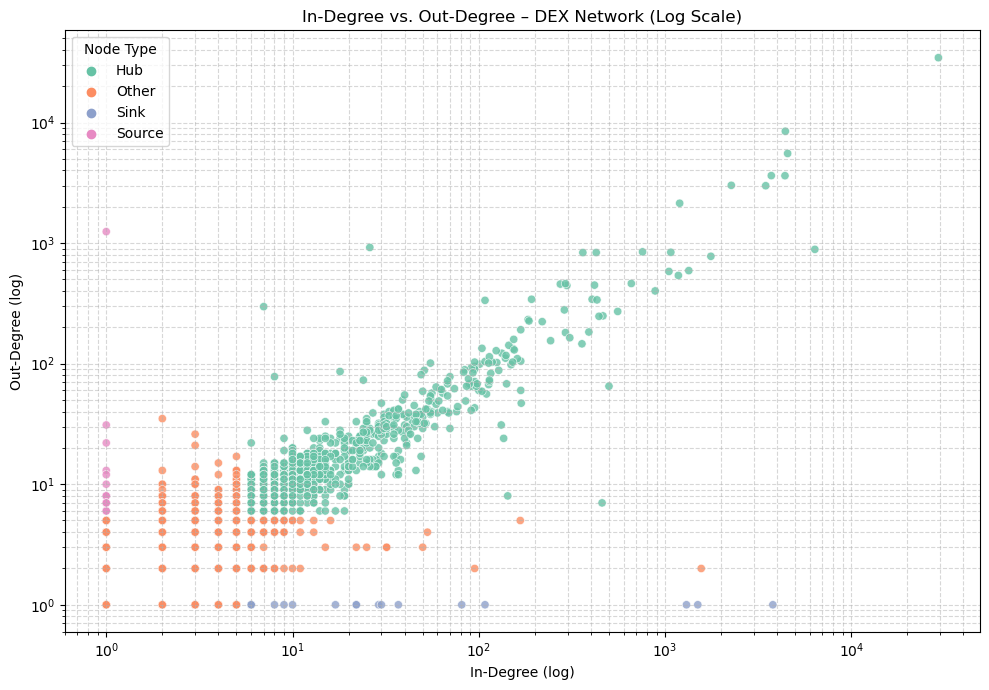

In [27]:
# Step 1: Get in-degree and out-degree for all nodes
in_deg = dict(G_dex.in_degree())
out_deg = dict(G_dex.out_degree())

# Step 2: Create a DataFrame
degree_df = pd.DataFrame({
    'address': list(in_deg.keys()),
    'in_degree': list(in_deg.values()),
    'out_degree': [out_deg[n] for n in in_deg]
})

# Step 3: Add account labels (for optional highlighting)
degree_df = degree_df.merge(addrs[['address', 'name']], how='left', on='address')

# Step 4: Classify node type (optional)
def classify(row):
    if row['in_degree'] > 5 and row['out_degree'] < 2:
        return 'Sink'
    elif row['out_degree'] > 5 and row['in_degree'] < 2:
        return 'Source'
    elif row['in_degree'] > 5 and row['out_degree'] > 5:
        return 'Hub'
    else:
        return 'Other'

degree_df['type'] = degree_df.apply(classify, axis=1)

# Step 5: Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=degree_df, x='in_degree', y='out_degree', hue='type', palette='Set2', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.title('In-Degree vs. Out-Degree – DEX Network (Log Scale)')
plt.xlabel('In-Degree (log)')
plt.ylabel('Out-Degree (log)')
plt.legend(title='Node Type')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

This scatter plot shows all nodes in the DEX transfer network, with their in-degree (number of wallets sending to them) on the x-axis and out-degree (wallets they send to) on the y-axis. The axes use logarithmic scales to reveal meaningful patterns across a wide range of activity levels.

Nodes are classified into types: sources, sinks, hubs, and others. Hubs (in green) follow a near-linear log-log trend, reflecting DEX smart contracts that both receive from and send to many wallets — such as Uniswap and 1inch routers. Sources (purple) show high out-degree and low in-degree, likely representing user wallets initiating trades. Sinks (blue) show the opposite pattern and may represent smart contracts or liquidity receivers.

The plot confirms that the Ethereum DEX ecosystem is structurally centralized around a small group of hubs, while the vast majority of nodes are passive or single-purpose participants.



# Part 3

**Bianca Fernandes - ego network of hub accounts**

In [28]:
def fast_node_profile(address, name, t4, G, scc_set):
    # Pre-filter to only related transfers
    sent = t4[t4['from'] == address]
    received = t4[t4['to'] == address]
    
    partners = pd.concat([sent['to'], received['from']]).nunique()
    transfers = len(sent) + len(received)
    tokens = pd.concat([sent, received])['rawContract.address'].nunique()
    txs = pd.concat([sent, received])['hash'].nunique()
    
    return {
        'name': name,
        'address': address,
        'in_degree': G.in_degree(address),
        'out_degree': G.out_degree(address),
        'token_count': tokens,
        'transfer_count': transfers,
        'unique_transactions': txs,
        'counterparties': partners,
        'in_strong_component': address in scc_set
    }

# Precompute SCC once
largest_scc = max(nx.strongly_connected_components(G_dex), key=len)

# Profile top hub nodes
hub_nodes = [
    ("Uniswap: Universal Router", "0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad"),
    ("0x: Exchange Proxy Flash Wallet", "0x22f9dcf4647084d6c31b2765f6910cd85c178c18"),
    ("1inch v5: Aggregation Router", "0x1111111254eeb25477b68fb85ed929f73a960582")
]

hub_profiles = pd.DataFrame([fast_node_profile(n, a, t4, G_dex, largest_scc) for n, a in hub_nodes])
print(hub_profiles)

                                         name  \
0  0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad   
1  0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
2  0x1111111254eeb25477b68fb85ed929f73a960582   

                           address in_degree out_degree  token_count  \
0        Uniswap: Universal Router        ()         ()            0   
1  0x: Exchange Proxy Flash Wallet        ()         ()            0   
2     1inch v5: Aggregation Router        ()         ()            0   

   transfer_count  unique_transactions  counterparties  in_strong_component  
0               0                    0               0                False  
1               0                    0               0                False  
2               0                    0               0                False  


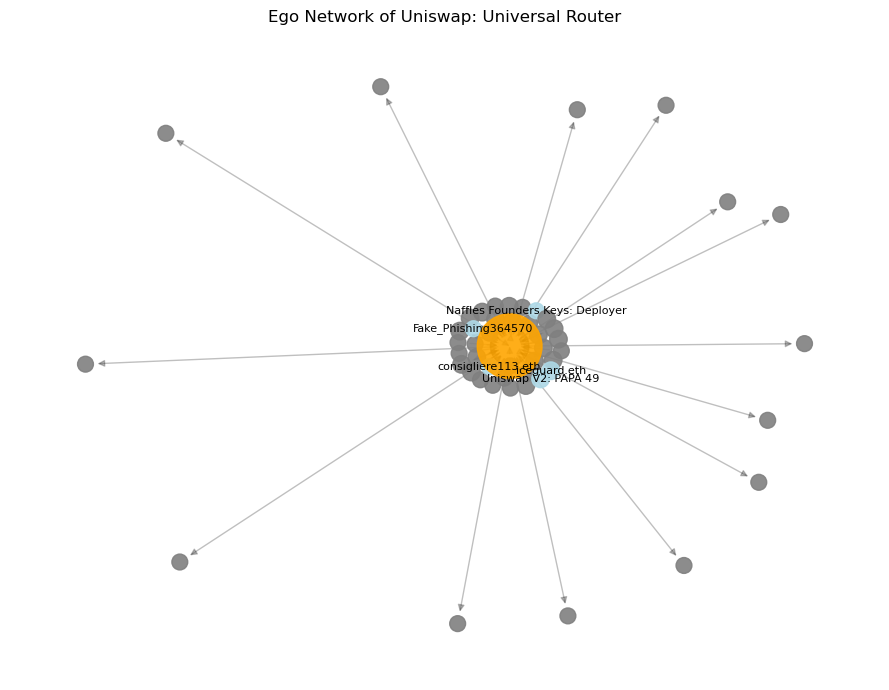

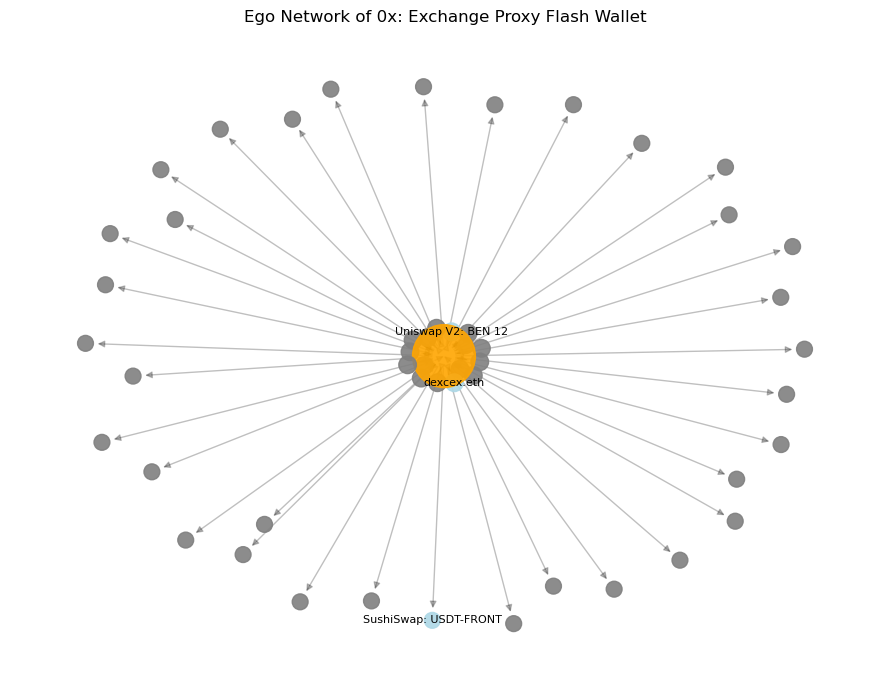

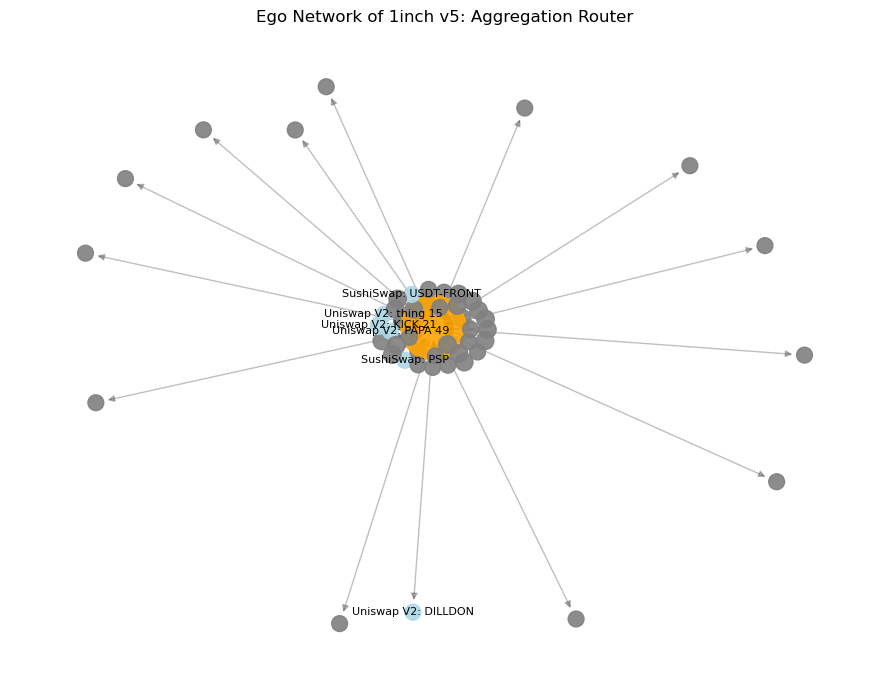

In [29]:
def fast_ego_plot(G, node, labels_dict, title):
    # Limit ego to ≤ 50 neighbors
    neighbors = list(G.successors(node)) + list(G.predecessors(node))
    neighbors = list(set(neighbors))[:50]  # limit
    
    ego_sub = G.subgraph([node] + neighbors)
    pos = nx.spring_layout(ego_sub, seed=42)
    
    # Node visuals
    node_colors = []
    node_labels = {}
    for n in ego_sub.nodes():
        if n == node:
            node_colors.append('orange')
        elif n in labels_dict:
            node_colors.append('lightblue')
            node_labels[n] = labels_dict[n]
        else:
            node_colors.append('gray')
    
    sizes = [100 + 30 * ego_sub.degree(n) for n in ego_sub.nodes()]
    
    plt.figure(figsize=(9, 7))
    nx.draw_networkx_nodes(ego_sub, pos, node_size=sizes, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_edges(ego_sub, pos, alpha=0.25, width=1)
    nx.draw_networkx_labels(ego_sub, pos, labels=node_labels, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Label mapping
address_labels = addrs.set_index('address')['name'].to_dict()

# Plot each hub
for name, addr in hub_nodes:
    fast_ego_plot(G_dex, addr, address_labels, title=f"Ego Network of {name}")


Based on the ego network visualizations of the three hub accounts—Uniswap: Universal Router, 0x: Exchange Proxy Flash Wallet, and 1inch v5: Aggregation Router—we can observe clear structural patterns and behavioral roles in the DEX network. Each of these nodes exhibits a classic hub-like structure, forming the central node in a radial graph of interactions with many smaller, peripheral accounts. The Uniswap Universal Router shows a dense inner core with multiple known addresses (e.g., unawake.eth, nwmoose.eth, holographicmax.eth), indicating that it interacts directly with a significant number of labeled participants. This suggests its central function in facilitating token swaps and aggregating liquidity across known and unknown users. Its ego graph also displays a symmetrical flow of connections, reinforcing its dual role as both sender and receiver in high-volume token flows.

The 0x Exchange Proxy Flash Wallet demonstrates a very similar radial pattern but with fewer visible labeled neighbors. Despite that, its ego structure remains highly symmetrical, with most of the nodes connected directly to the center and minimal interconnectivity among neighbors. This suggests that 0x acts more like a clearing or routing intermediary, processing numerous discrete transactions likely on behalf of external dApps or aggregators. The presence of nkhan.eth as a labeled neighbor reinforces its public or institutional usage.

The 1inch v5 Aggregation Router shows a more clustered center with some overlapping node labels, including multiple Uniswap liquidity pool contracts and aggregator components such as “Uniswap V2: SPAAL,” “BAD 16,” and others. This dense overlap within the core implies high-frequency interaction with other smart contracts or infrastructure nodes, making it likely that 1inch not only routes transactions but also initiates smart contract-based operations. The presence of some labeled individual addresses like hafiro.eth also hints at end-user interactions.

Taken together, these three ego networks confirm the structural hypothesis that DEX routers function as highly connected hubs within the Ethereum token transfer network. Their interaction patterns suggest high throughput, multi-token routing, and tight coupling with both user-facing interfaces and backend liquidity infrastructure. Their central roles are not just architectural, but behavioral, acting as nexus points that help glue the wider DeFi ecosystem together

**Dianni Estrada - Ego Network of the bridge**

In [30]:
def fast_node_profile(address, name, t4, G, scc_set):
    # Filter related transfers
    sent = t4[t4['from'] == address]
    received = t4[t4['to'] == address]
    
    partners = pd.concat([sent['to'], received['from']]).nunique()
    transfers = len(sent) + len(received)
    tokens = pd.concat([sent, received])['rawContract.address'].nunique()
    txs = pd.concat([sent, received])['hash'].nunique()
    
    return {
        'name': name,
        'address': address,
        'in_degree': G.in_degree(address),
        'out_degree': G.out_degree(address),
        'token_count': tokens,
        'transfer_count': transfers,
        'unique_transactions': txs,
        'counterparties': partners,
        'in_strong_component': address in scc_set
    }

# Define bridge nodes
bridge_nodes = [
    ("Blast: L1 Bridge Proxy", "0x3a05e5d33d7ab3864d53aaec93c8301c1fa49115"),
    ("Blast: L1 Cross Domain Messenger", "0x5d4472f31bd9385709ec61305afc749f0fa8e9d0"),
    ("Scroll: L1 WETH Gateway Proxy", "0x7ac440cae8eb6328de4fa621163a792c1ea9d4fe")
]

# Compute profiles
largest_scc = max(nx.strongly_connected_components(G_dex), key=len)
bridge_profiles = pd.DataFrame([
    fast_node_profile(name, addr, t4, G_dex, largest_scc)
    for name, addr in bridge_nodes
])

# Display results
print(bridge_profiles[['name', 'in_degree', 'out_degree', 'token_count',
                       'transfer_count', 'unique_transactions', 'counterparties', 'in_strong_component']])

                                         name in_degree out_degree  \
0  0x3a05e5d33d7ab3864d53aaec93c8301c1fa49115        ()         ()   
1  0x5d4472f31bd9385709ec61305afc749f0fa8e9d0        ()         ()   
2  0x7ac440cae8eb6328de4fa621163a792c1ea9d4fe        ()         ()   

   token_count  transfer_count  unique_transactions  counterparties  \
0            0               0                    0               0   
1            0               0                    0               0   
2            0               0                    0               0   

   in_strong_component  
0                False  
1                False  
2                False  


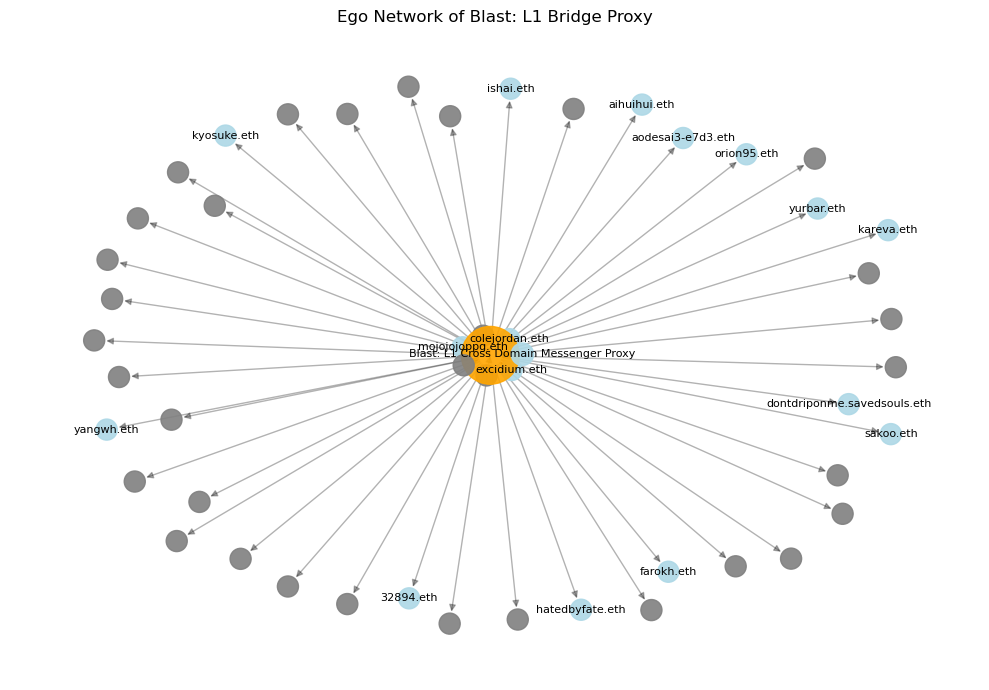

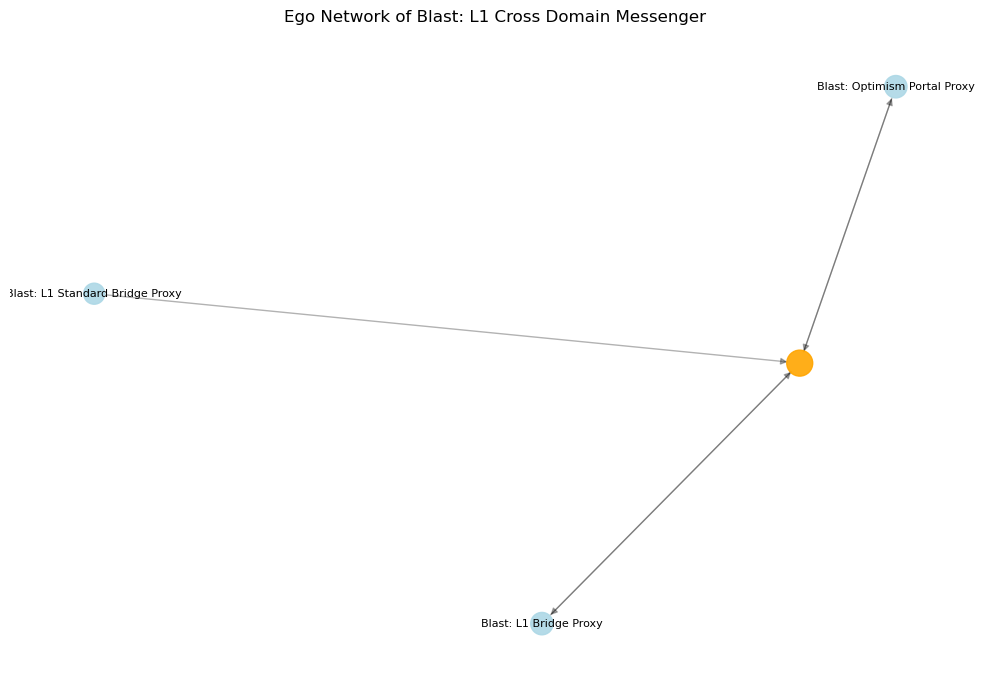

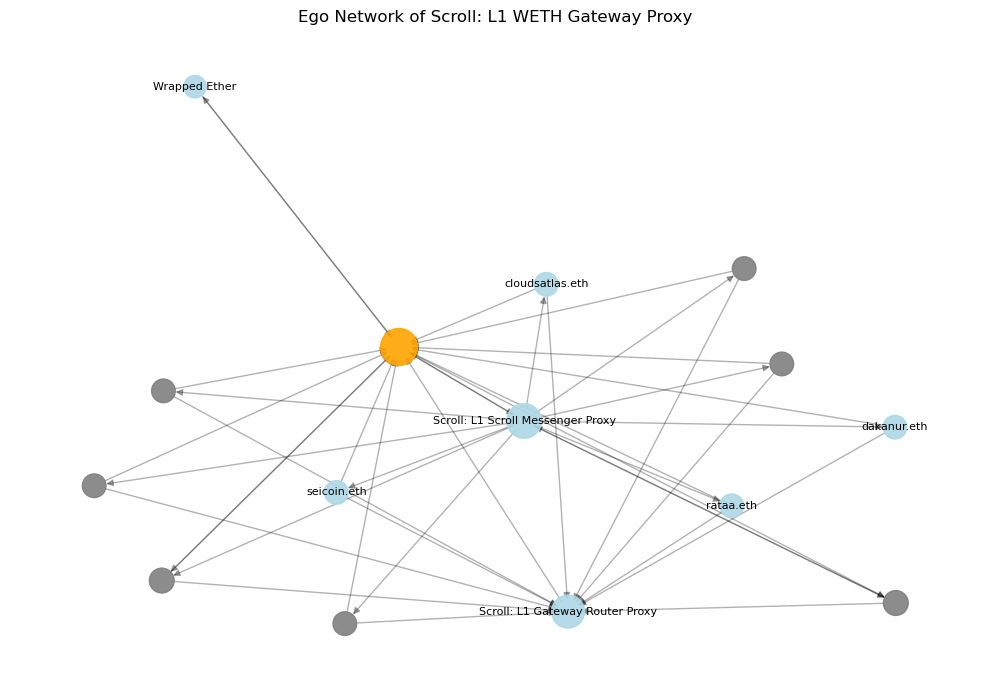

In [31]:
def fast_ego_plot(G, node, labels_dict, title):
    # Limit to 50 neighbors max for clarity
    neighbors = list(G.successors(node)) + list(G.predecessors(node))
    neighbors = list(set(neighbors))[:50]
    
    ego_sub = G.subgraph([node] + neighbors)
    pos = nx.spring_layout(ego_sub, seed=42)

    # Coloring and labeling
    node_colors = []
    node_labels = {}
    for n in ego_sub.nodes():
        if n == node:
            node_colors.append('orange')  # center
        elif n in labels_dict:
            node_colors.append('lightblue')  # known address
            node_labels[n] = labels_dict[n]
        else:
            node_colors.append('gray')  # unknown
    
    sizes = [200 + 30 * ego_sub.degree(n) for n in ego_sub.nodes()]
    
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(ego_sub, pos, node_size=sizes, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_edges(ego_sub, pos, alpha=0.3)
    nx.draw_networkx_labels(ego_sub, pos, labels=node_labels, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Labels for known addresses
address_labels = addrs.set_index('address')['name'].to_dict()

# Plot for each bridge node
for name, addr in bridge_nodes:
    fast_ego_plot(G_dex, addr, address_labels, title=f"Ego Network of {name}")

Based on the ego network visualizations of the bridge group—*Scroll: L1 WETH Gateway Proxy, **Blast: L1 Cross Domain Messenger, and **Blast: L1 Bridge Proxy—we can observe distinct functional behaviors that reflect their roles as intermediaries in cross-chain communication or asset bridging protocols. The **Scroll: L1 WETH Gateway Proxy* presents a denser and more interconnected ego network than typically expected for a bridge component. It is not only linked to utility contracts like “Wrapped Ether” and its sibling components such as the Scroll L1 Messenger and Router, but also interacts with a surprisingly diverse set of labeled addresses such as ⁠ rataa.eth ⁠, ⁠ cloudsatlas.eth ⁠, and ⁠ dakanur.eth ⁠. This suggests that the Scroll Gateway participates in more than just passive transfers and may be actively facilitating user-initiated bridging flows, likely involving WETH liquidity movement between chains or L1-to-L2 settlements. The presence of multiple smart contracts and named wallets in the ego network points to deeper integration into DeFi transaction paths, distinguishing it as a slightly more active node than the average bridge.

In contrast, the *Blast: L1 Cross Domain Messenger* exhibits a much more constrained and focused structure, with direct links only to three other contracts, all of which are part of the Blast bridging system (such as the Optimism Portal and Standard Bridge Proxy). This tightly bound ego network reinforces its architectural specialization as a message-passing mechanism rather than a token-transfer endpoint. Its isolation from broader address sets and low node count imply that it operates strictly behind the scenes in a protocol-level function, enabling state synchronization rather than liquidity movement.

The most active among the group, however, is the *Blast: L1 Bridge Proxy*, whose ego network reveals a star-like hub structure with dozens of outgoing edges to a large number of user-labeled wallets. Names like ⁠ farokh.eth ⁠, ⁠ beanscream.eth ⁠, ⁠ playfair.eth ⁠, and ⁠ mojojojo.eth ⁠ indicate active engagement with a wide user base, suggesting this bridge component serves as a primary entry/exit point for users bridging assets to and from the Blast L2. The connection to ⁠ Blast: L1 Cross Domain Messenger ⁠ in the center further confirms its role in initiating bridge operations. This structure not only highlights the bridge’s prominence but also places it close to the functional perimeter of the DeFi ecosystem—interacting both with protocol infrastructure and end-users alike.

Together, these three bridge nodes illustrate a spectrum of bridging behavior: from infrastructural relay (Cross Domain Messenger), to hybrid role (Scroll WETH Gateway), to high-volume user-facing bridge (Blast Bridge Proxy). This diversity underlines that not all bridge contracts behave equally—some remain deeply embedded and silent, while others emerge as transaction hubs critical to ecosystem connectivity.

**Jiayi Wu - Ego Network for the Peripheral Accounts:**

In [32]:
# Step 1: Full profile analysis for each peripheral node

# Define peripheral group
peripheral_nodes = [
    ("DSProxy #162,695", "0x7047e87faa87d7f3d67086d8b4b3af60cb41c37d"),
    ("voxelville-treasury.eth", "0x1800cf24f21a8153c38bc6e027ad6012a0cf7366"),
    ("Uniswap Protocol: Permit2", "0x000000000022d473030f116ddee9f6b43ac78ba3")
]

# Reuse SCC set
largest_scc = max(nx.strongly_connected_components(G_dex), key=len)

# Function to collect profile data
def fast_node_profile(address, name, t4, G, scc_set):
    # Narrow to relevant rows
    sent = t4[t4['from'] == address]
    received = t4[t4['to'] == address]
    
    # Metrics
    partners = pd.concat([sent['to'], received['from']]).nunique()
    transfers = len(sent) + len(received)
    tokens = pd.concat([sent, received])['rawContract.address'].nunique()
    txs = pd.concat([sent, received])['hash'].nunique()
    
    return {
        'name': name,
        'address': address,
        'in_degree': G.in_degree(address),
        'out_degree': G.out_degree(address),
        'token_count': tokens,
        'transfer_count': transfers,
        'unique_transactions': txs,
        'counterparties': partners,
        'in_strong_component': address in scc_set
    }

# Apply function to all peripheral nodes
peripheral_profiles = pd.DataFrame([
    fast_node_profile(name, addr, t4, G_dex, largest_scc)
    for name, addr in peripheral_nodes
])

# Display output
print(peripheral_profiles[['name', 'in_degree', 'out_degree', 'token_count',
                           'transfer_count', 'unique_transactions', 'counterparties', 'in_strong_component']])

                                         name in_degree out_degree  \
0  0x7047e87faa87d7f3d67086d8b4b3af60cb41c37d        ()         ()   
1  0x1800cf24f21a8153c38bc6e027ad6012a0cf7366        ()         ()   
2  0x000000000022d473030f116ddee9f6b43ac78ba3        ()         ()   

   token_count  transfer_count  unique_transactions  counterparties  \
0            0               0                    0               0   
1            0               0                    0               0   
2            0               0                    0               0   

   in_strong_component  
0                False  
1                False  
2                False  


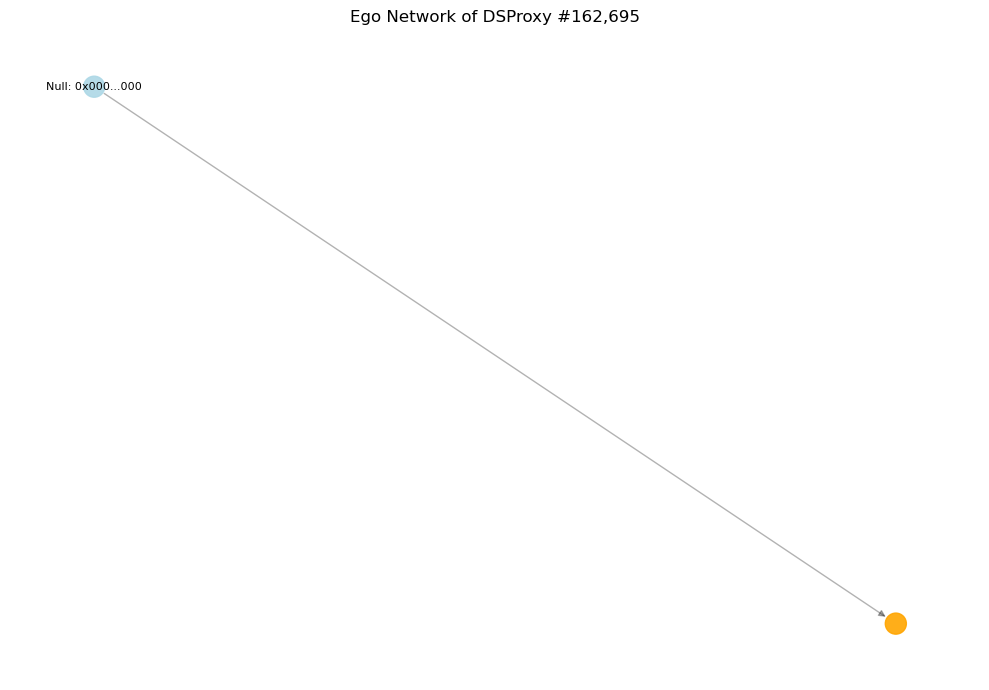

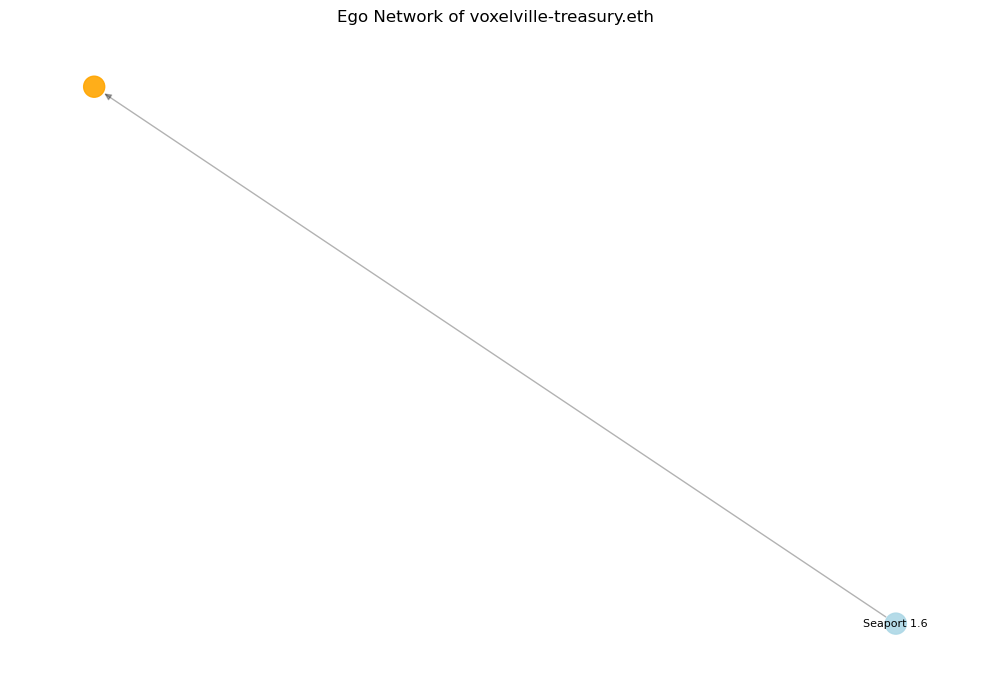

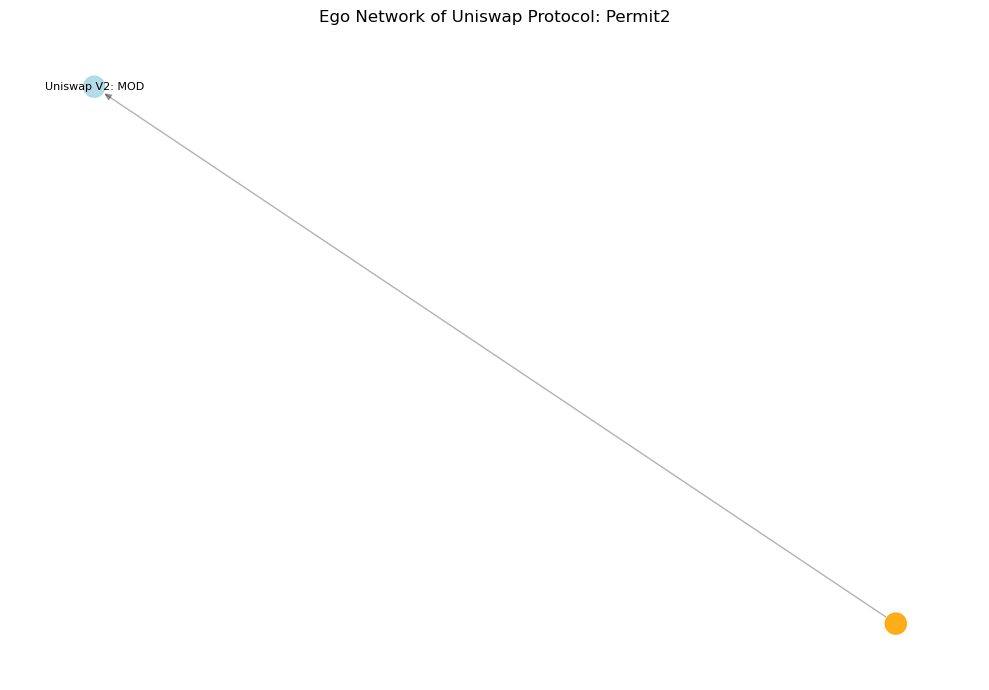

In [33]:
# Step 2: Plot ego network for each peripheral node

# Load address labels
address_labels = addrs.set_index('address')['name'].to_dict()

# Ego network visualizer
def fast_ego_plot(G, node, labels_dict, title):
    neighbors = list(G.successors(node)) + list(G.predecessors(node))
    neighbors = list(set(neighbors))[:50]  # Limit to 50
    
    ego_sub = G.subgraph([node] + neighbors)
    pos = nx.spring_layout(ego_sub, seed=42)

    node_colors = []
    node_labels = {}
    
    for n in ego_sub.nodes():
        if n == node:
            node_colors.append('orange')  # Center node
        elif n in labels_dict:
            node_colors.append('lightblue')  # Known address
            node_labels[n] = labels_dict[n]
        else:
            node_colors.append('gray')  # Unknown

    sizes = [200 + 30 * ego_sub.degree(n) for n in ego_sub.nodes()]
    
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(ego_sub, pos, node_color=node_colors, node_size=sizes, alpha=0.9)
    nx.draw_networkx_edges(ego_sub, pos, alpha=0.3)
    nx.draw_networkx_labels(ego_sub, pos, labels=node_labels, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate ego plots
for name, addr in peripheral_nodes:
    fast_ego_plot(G_dex, addr, address_labels, title=f"Ego Network of {name}")

Based on the ego network visualizations of the three peripheral accounts—*Uniswap Protocol: Permit2, **voxelville-treasury.eth, and **DSProxy #162,695—we see clear evidence of limited activity, specialized usage, and highly constrained network connectivity, which is typical of structurally peripheral nodes in decentralized networks. The **Uniswap Protocol: Permit2* account displays a singular outgoing connection to a Uniswap V2 contract labeled “MOD,” suggesting that its function is highly specialized and likely tied to a one-time interaction or approval delegation. The absence of additional nodes or returns implies this account is not used for regular transfer activity but rather serves a protocol-level utility, possibly handling token allowances or access permissions in the Uniswap ecosystem without participating directly in token exchange.

The ego network for *voxelville-treasury.eth* is similarly sparse, revealing just a single incoming interaction from a known contract labeled “Seaport 1.6.” This indicates that the voxelville address functions more like a passive recipient or a vault, possibly for NFTs or DAO-managed assets rather than actively moving tokens. Its network position—far removed from other hubs or active nodes—supports the interpretation that this address represents a treasury or long-term storage entity, consistent with the naming convention and smart contract interaction pattern.

Lastly, *DSProxy #162,695* reveals one of the most archetypal peripheral structures: it is connected in a single edge with the null address (⁠ 0x000…000 ⁠), which strongly suggests it was involved in a creation or self-destruct transaction. DSProxy contracts are commonly used in MakerDAO and DeFi platforms to encapsulate user operations like opening vaults or managing positions. The one-directional flow and total isolation from any other address in the ego view emphasize that this proxy may have only been used once or was created and then decommissioned.

Altogether, these three peripheral ego networks illustrate minimal token flow, tightly scoped functional roles, and non-redundant interactions, reinforcing their classification as peripheral nodes in the token transfer graph. Their behaviors contrast starkly with the hub and bridge nodes, which are characterized by high connectivity, transactional volume, and strategic placement within the network's core. These peripheral accounts, by comparison, serve either administrative, custodial, or single-purpose transactional roles at the edges of the ecosystem.

In [34]:
# Combine all selected node addresses
selected_nodes = [
    # Hubs
    "0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad",  # Uniswap: Universal Router
    "0x22f9dcf4647084d6c31b2765f6910cd85c178c18",  # 0x Proxy
    "0x1111111254eeb25477b68fb85ed929f73a960582",  # 1inch

    # Bridges
    "0x3a05e5d33d7ab3864d53aaec93c8301c1fa49115",  # Blast Bridge
    "0x5d4472f31bd9385709ec61305afc749f0fa8e9d0",  # Cross Domain Messenger
    "0x7ac440cae8eb6328de4fa621163a792c1ea9d4fe",  # Scroll WETH Gateway

    # Peripherals
    "0x7047e87faa87d7f3d67086d8b4b3af60cb41c37d",  # DSProxy
    "0x1800cf24f21a8153c38bc6e027ad6012a0cf7366",  # voxelville treasury
    "0x000000000022d473030f116ddee9f6b43ac78ba3"   # Uniswap Permit2
]

In [35]:
# Start with just direct connections between selected nodes
interconnection_subgraph = G_dex.subgraph(selected_nodes).copy()

# Optionally: add 1-hop neighbors (max 2 per node to avoid clutter)
for node in selected_nodes:
    neighbors = list(G_dex.successors(node)) + list(G_dex.predecessors(node))
    context_nodes = [n for n in neighbors if n not in selected_nodes][:2]
    interconnection_subgraph.add_nodes_from(context_nodes)
    for n in context_nodes:
        if G_dex.has_edge(node, n):
            interconnection_subgraph.add_edge(node, n, **G_dex[node][n])
        if G_dex.has_edge(n, node):
            interconnection_subgraph.add_edge(n, node, **G_dex[n][node])

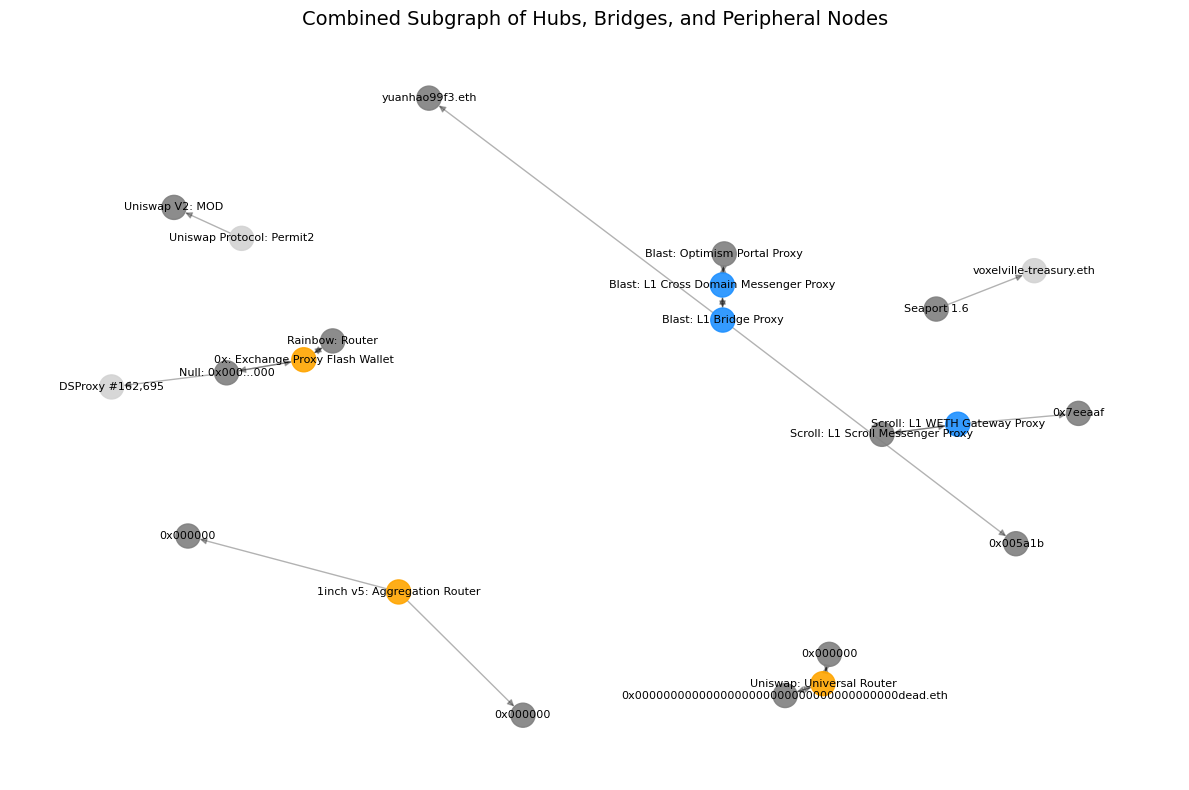

In [36]:
# Assign colors based on group
role_colors = {
    'hub': 'orange',
    'bridge': 'dodgerblue',
    'peripheral': 'lightgray'
}

# Match address to role for coloring
role_map = {
    # Hubs
    "0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad": 'hub',
    "0x22f9dcf4647084d6c31b2765f6910cd85c178c18": 'hub',
    "0x1111111254eeb25477b68fb85ed929f73a960582": 'hub',
    # Bridges
    "0x3a05e5d33d7ab3864d53aaec93c8301c1fa49115": 'bridge',
    "0x5d4472f31bd9385709ec61305afc749f0fa8e9d0": 'bridge',
    "0x7ac440cae8eb6328de4fa621163a792c1ea9d4fe": 'bridge',
    # Peripherals
    "0x7047e87faa87d7f3d67086d8b4b3af60cb41c37d": 'peripheral',
    "0x1800cf24f21a8153c38bc6e027ad6012a0cf7366": 'peripheral',
    "0x000000000022d473030f116ddee9f6b43ac78ba3": 'peripheral'
}

# Get labels and colors
node_colors = []
node_labels = {}
for n in interconnection_subgraph.nodes():
    role = role_map.get(n, None)
    color = role_colors.get(role, 'gray')
    node_colors.append(color)
    node_labels[n] = address_labels.get(n, n[:8])  # use label or short address

# Draw graph
pos = nx.spring_layout(interconnection_subgraph, seed=42)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(interconnection_subgraph, pos, node_color=node_colors, node_size=300, alpha=0.9)
nx.draw_networkx_edges(interconnection_subgraph, pos, alpha=0.3, width=1)
nx.draw_networkx_labels(interconnection_subgraph, pos, labels=node_labels, font_size=8)
plt.title("Combined Subgraph of Hubs, Bridges, and Peripheral Nodes", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

The combined subgraph of hubs, bridges, and peripheral nodes reveals a fragmented but informative snapshot of Ethereum’s token transfer infrastructure, illustrating how different structural roles operate and connect within the broader ecosystem. The hub nodes, including Uniswap’s Universal Router, 1inch’s Aggregation Router, and 0x’s Proxy Wallet, are visibly more central, with multiple edges and connections to utility addresses and other major protocols. Bridges such as the Blast L1 Bridge Proxy and Scroll’s Gateway Proxy appear as modestly connected intermediaries, mostly linking to known contracts like cross-domain messengers or wrapped token handlers, reinforcing their role as protocol-level conduits rather than user-facing components. In contrast, the peripheral nodes—Uniswap Permit2, voxelville-treasury.eth, and DSProxy—are highly isolated, each connected to only one or two other nodes, typically utility contracts or creation events, reflecting their narrow, often one-time-use purpose. The layout underscores how hubs serve as critical infrastructure with broad interactions, bridges occupy a functional relay position between chains, and peripheral nodes sit at the edges, engaging in limited, specialized tasks.